**Goal**    
Exploration of various metrics and behaviours for different model selection criteria

In [242]:
import sys
sys.path.insert(1, "..")
import pprint
import torch
import numpy as np
import metrics
import copy
import configparser
from experiment_functions import Experiment
from GaussianProcess import ExactGPModel
from globalParams import options, hyperparameter_limits
import gpytorch
from helpFunctions import get_string_representation_of_kernel as gsr
from helpFunctions import clean_kernel_expression
from helpFunctions import get_kernels_in_kernel_expression, get_full_kernels_in_kernel_expression
from helpFunctions import amount_of_base_kernels
from itertools import product
import json
from kernelSearch import *
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from metrics import *
from multiprocessing import Pool
import numpy as np
import os
import pdb
import pickle
import random
import tikzplotlib
import time
import torch
from tqdm import tqdm
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from pygranso.pygranso import pygranso
from pygranso.pygransoStruct import pygransoStruct
from pygranso.private.getNvar import getNvarTorch

In [243]:
# Stolen from https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
def confidence_ellipse(mu, K, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The Axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = K
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mu[0] 

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mu[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [244]:
def random_reinit(model):
    for i, (param, limit) in enumerate(zip(model.parameters(), [{"Noise": hyperparameter_limits["Noise"]},*[hyperparameter_limits[kernel] for kernel in get_full_kernels_in_kernel_expression(model.covar_module)]])):
        covar_text = gsr(model.covar_module)
        param_name = list(limit.keys())[0]
        new_param_value = torch.randn_like(param) * (limit[param_name][1] - limit[param_name][0]) + limit[param_name][0]
        param.data = new_param_value


def optimize_hyperparameters(model, likelihood, **kwargs):
    """
    find optimal hyperparameters either by BO or by starting from random initial values multiple times, using an optimizer every time
    and then returning the best result
    """
    random_restarts = kwargs.get("random_restarts", options["training"]["restarts"]+1)
    # Use kwargs if not None, otherwise use the default values
    train_x = kwargs.get("train_x", model.train_inputs[0])
    train_y = kwargs.get("train_y", model.train_targets)

    # Define the negative log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    # Set up the PyGRANSO optimizer
    opts = pygransoStruct()
    opts.torch_device = torch.device('cpu')
    nvar = getNvarTorch(model.parameters())
    opts.x0 = torch.nn.utils.parameters_to_vector(model.parameters()).detach().reshape(nvar,1)
    opts.opt_tol = 1e-10
    opts.limited_mem_size = 100
    opts.globalAD = True
    opts.quadprog_info_msg = False
    opts.print_level = 0
    opts.halt_on_linesearch_bracket = False
    opts.double_precision = False

    # Define the objective function
    def objective_function(model):
        output = model(train_x)
        loss = -mll(output, train_y)
        log_p = metrics.log_normalized_prior(model)
        loss -= log_p
        return [loss, None, None]

    best_model_state_dict = model.state_dict()
    best_likelihood_state_dict = likelihood.state_dict()

    random_restarts = 5
    best_f = np.inf
    for restart in range(random_restarts):
        # Train the model using PyGRANSO
        soln = pygranso(var_spec=model, combined_fn=objective_function, user_opts=opts)
        if soln.final.f < best_f:
            best_f = soln.final.f
            best_model_state_dict = model.state_dict()
            best_likelihood_state_dict = likelihood.state_dict()
        print(f"post training (final): {list(model.named_parameters())} w. loss: {soln.final.f}")
        random_reinit(model)

    model.load_state_dict(best_model_state_dict)
    likelihood.load_state_dict(best_likelihood_state_dict)

    loss = -mll(model(train_x), train_y)
    log_p = metrics.log_normalized_prior(model)
    loss -= log_p

    print(f"post training (best): {list(model.named_parameters())} w. loss: {soln.best.f}")
    print(f"post training (final): {list(model.named_parameters())} w. loss: {soln.final.f}")
    print(torch.autograd.grad(loss, [p for p in model.parameters()], retain_graph=True, create_graph=True, allow_unused=True))
    # Return the trained model
    return loss, model, likelihood

def get_std_points(mu, K):
    x, y = np.mgrid[-3:3:.1, -3:3:.1]
    rv = multivariate_normal(mu, K)
    L = np.linalg.cholesky(K)

    data = np.dstack((x, y))
    z = rv.pdf(data)

    # Drawing the unit circle
    # x^2 + y^2 = 1
    precision = 50
    unit_x = torch.cat([torch.linspace(-1, 1, precision), torch.linspace(-1, 1, precision)])
    unit_y = torch.cat([torch.sqrt(1 - torch.linspace(-1, 1, precision)**2), -torch.sqrt(1 - torch.linspace(-1, 1, precision)**2)])

    new_unit_x = list()
    new_unit_y = list()

    for tx, ty in zip(unit_x, unit_y):
        res = np.array([tx, ty]) @ L
        new_unit_x.append(mu[0] + 2*res[0])
        new_unit_y.append(mu[1] + 2*res[1])
    return new_unit_x, new_unit_y


# Find all points inside the confidence ellipse
def percentage_inside_ellipse(mu, K, points, sigma_level=2):
    L = np.linalg.cholesky(K)
    threshold = sigma_level ** 2
    count = 0
    for point in points:
        res = np.array(point - mu) @ np.linalg.inv(L)
        if res @ res <= threshold:
            count += 1
    return count / len(points)

In [245]:
# from metrics.py
# Used to generate the parameter prior for the specific class of GP kernel and calculate the log propability of this specific parametrization
#metrics.prior_distribution()
#metrics.log_normalized_prior()

# Definitions

In [246]:
# Global name
data_generation = "linear_noise" # linear, linear_noise, 2_points
COUNT = 2 if data_generation == "2_points" else 4
evaluating_GP_model = "RBF" # RBF, Linear, RQ, MAT32, MAT52; Optionally also "C*RBF" etc.
# timestamp in yyyy-mm-dd-hh-mm-ss
timestamp = time.strftime("%Y-%m-%d-%H-%M-%S")

log_path = f"logs/{timestamp}_{data_generation}{COUNT}-{evaluating_GP_model}"
# Create the log directory
os.makedirs(log_path)

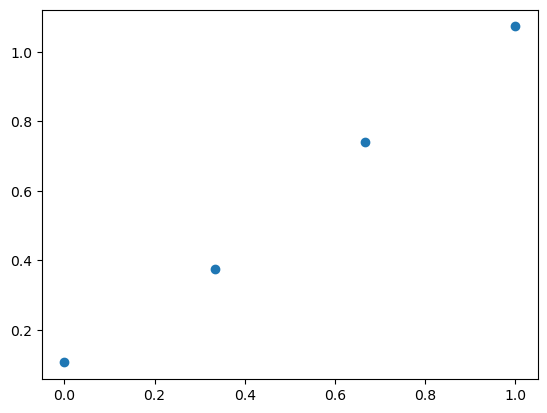

In [247]:
# Data
torch.manual_seed(42)
END = 1

train_x = torch.linspace(0, END, COUNT)

if "linear" in data_generation:
    train_y = torch.linspace(0, END, COUNT)
elif data_generation == "2_points":
    train_y = torch.tensor([0, 1])
if "noise" in data_generation:
    train_y += torch.randn(train_x.size()) * torch.sqrt(torch.tensor(0.1))
plt.plot(train_x, train_y, "o")

# Model definition

In [248]:
# RBF, Linear, RQ, MAT32, MAT52
if evaluating_GP_model == "RBF":
    kernel = gpytorch.kernels.RBFKernel()
elif evaluating_GP_model == "Linear":
    kernel = gpytorch.kernels.LinearKernel()
elif evaluating_GP_model == "RQ":
    kernel = gpytorch.kernels.RQKernel()
elif evaluating_GP_model == "MAT32":
    kernel = gpytorch.kernels.MaternKernel(nu=3/2)
elif evaluating_GP_model == "MAT52":
    kernel = gpytorch.kernels.MaternKernel(nu=5/2)


if "C*" in evaluating_GP_model:
    kernel = gpytorch.kernels.ScaleKernel(kernel)


In [249]:
# Simplest GP possible. SE with constant sigma_f 
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = kernel 

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood, kernel)

# Training

In [250]:
loss, model, likelihood = optimize_hyperparameters(model, likelihood)

post training (final): [('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-7.3612], requires_grad=True)), ('covar_module.raw_lengthscale', Parameter containing:
tensor([[0.8903]], requires_grad=True))] w. loss: 0.9524757488249511
post training (final): [('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-7.3612], requires_grad=True)), ('covar_module.raw_lengthscale', Parameter containing:
tensor([[0.8903]], requires_grad=True))] w. loss: 0.9524757488249511
post training (final): [('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-7.3612], requires_grad=True)), ('covar_module.raw_lengthscale', Parameter containing:
tensor([[0.8903]], requires_grad=True))] w. loss: 0.9524757488249511
post training (final): [('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-7.3612], requires_grad=True)), ('covar_module.raw_lengthscale', Parameter containing:
tensor([[0.8903]], requires_grad=True))] w. loss: 0.9524757488249511
post trainin

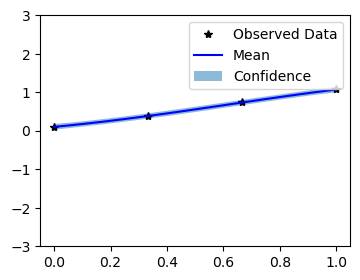

In [251]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    a = model(test_x)
    observed_pred = likelihood(a)
    
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

    plt.savefig(f"{log_path}/gp_fit.png")

# Laplace

In [252]:
model.train()
likelihood.train()

lap, lap_log = metrics.calculate_laplace(model, -loss*COUNT, with_prior=True, param_punish_term=0.0) # Param_punish 0.0, -1.0, BIC
lap_param_mu = lap_log["parameter values"]
lap_param_std = lap_log["corrected Hessian"]
print(lap)
print(lap_log)

tensor(-3.8100, grad_fn=<AddBackward0>)
{'neg MLL': tensor(3.8099, grad_fn=<NegBackward0>), 'punish term': tensor(-7.7066e-05), 'laplace without replacement': tensor(-1.2718, grad_fn=<SubBackward0>), 'num_replaced': tensor(2), 'parameter list': ['likelihood.noise_covar.raw_noise', 'covar_module.raw_lengthscale'], 'Jacobian': (tensor([-7.5489e-12], grad_fn=<AddBackward0>), tensor([[1.0144e-09]], grad_fn=<AddBackward0>)), 'parameter values': tensor([[-7.3612],
        [ 0.8903]]), 'corrected Hessian': tensor([[ 6.2832e+00, -1.1102e-16],
        [ 1.1102e-16,  6.2832e+00]]), 'diag(constructed eigvals)': tensor([6.2832, 6.2832]), 'original symmetrized Hessian': tensor([[ 0.2320, -0.1171],
        [-0.1171,  1.1213]]), 'prior mean': tensor([[-3.5164],
        [-0.2122]]), 'diag(prior var)': tensor([12.8388,  3.5704]), 'likelihood approximation': tensor(-3.8100, grad_fn=<AddBackward0>), 'Derivative time': 0.0012257099151611328, 'Approximation time': 0.00022339820861816406, 'Correction time':

# AIC

In [253]:
model.train()
likelihood.train()

aic, aic_log = metrics.calculate_AIC(-loss, len(list(model.parameters())))
print(aic)
print(aic_log)

tensor(-5.9050, grad_fn=<AddBackward0>)
{'punish term': 4, 'Total time': 6.103515625e-05, 'loss term': tensor(-1.9050, grad_fn=<MulBackward0>)}


# BIC

In [254]:
model.train()
likelihood.train()

bic, bic_log = metrics.calculate_BIC(-loss, len(list(model.parameters())), torch.tensor(COUNT))
print(bic)
print(bic_log)

tensor(-4.6775, grad_fn=<AddBackward0>)
{'punish term': tensor(-2.7726), 'Total time': 7.224082946777344e-05, 'loss term': tensor(-1.9050, grad_fn=<MulBackward0>)}


# Nested Sampling (Model evidence)

In [255]:
model.train()
likelihood.train()

model_evidence, model_evidence_log = metrics.NestedSampling(model, 
                                                            print_progress=True,
                                                            store_samples = True,
                                                            store_likelihoods = True,
                                                            store_full = True,
                                                            pickle_directory = f"{log_path}/"
                                                            )
print(model_evidence)
print(model_evidence_log)

Random seed: 44160


13290it [01:10, 188.38it/s, batch: 7 | bound: 0 | nc: 1 | ncall: 64885 | eff(%): 20.482 | loglstar:   -inf <  1.050 <  0.097 | logz: -1.556 +/-  0.035 | stop:  0.912]          

-1.5776067806425662
{'Sample time': 70.55183982849121, 'log Z': -1.5776067806425662, 'log Z err': 0.03385854319927719, 'prior mean': tensor([[-3.5164],
        [-0.2122]]), 'prior cov': tensor([[12.8388,  0.0000],
        [ 0.0000,  3.5704]]), 'dynamic': True, 'num sampled': 13290, 'parameter statistics': {'mu': array([-6.66373019,  0.72658317]), 'std': array([3.06444137, 1.07266663])}, 'res file': 'logs/2024-09-26-13-25-59_linear_noise4-RBF/Nested_results/res_1727350031.1098304.pkl'}


In [256]:
# unpickle the log file
with open(f"{model_evidence_log['res file']}", "rb") as f:
    res = pickle.load(f)

In [257]:
# Calculate the amount of samples that are covered by the 1 sigma and 2 sigma interval based on the lap_mu and lap_cov values
lap_2_sig_coverage = percentage_inside_ellipse(lap_param_mu.flatten().numpy(), lap_param_std.numpy(), res.samples)
lap_2_sig_coverage

0.5429646350639579

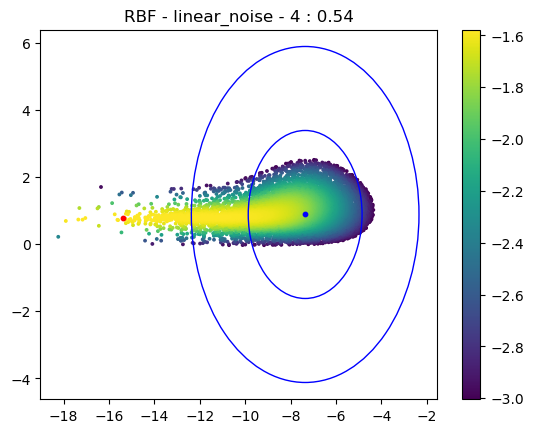

In [258]:

f, ax = plt.subplots()

# Find the best value and the corresponding hyperparameters
best_idx = np.argmax(res.logz)
best_hyperparameters = res.samples[best_idx]

# Do an outlier cleanup on res.logz
logz_mean = np.mean(res.logz)
logz_std = np.std(res.logz)
std_filter = -0.0
mask = res.logz >= logz_mean+std_filter*logz_std


likelihood_surface_scatter = ax.scatter(res.samples[:,0][mask], res.samples[:,1][mask], c=res.logz[mask], s=3)
# Best found hyperparameters
ax.scatter(best_hyperparameters[0], best_hyperparameters[1], c="r", s=10)
# Plot the std points
lap_var_ellipse_x, lap_var_ellipse_y = get_std_points(lap_param_mu.numpy().reshape(-1), lap_param_std.numpy())
#plt.scatter(lap_var_ellipse_x, lap_var_ellipse_y, c="b", s=1)
confidence_ellipse(lap_param_mu.numpy(), lap_param_std.numpy(), ax, n_std=1, edgecolor='b', lw=1)
confidence_ellipse(lap_param_mu.numpy(), lap_param_std.numpy(), ax, n_std=2, edgecolor='b', lw=1)
ax.scatter(lap_param_mu[0], lap_param_mu[1], c="b", s=10)

plt.title(f"{evaluating_GP_model} - {data_generation} - {COUNT} : {lap_2_sig_coverage:.2f}")

plt.colorbar(likelihood_surface_scatter)
f.savefig(f"{log_path}/likelihood_surface_>={logz_mean:.2f}{std_filter:.2f}.png")

In [259]:
all_logs = {"MAP": -loss*COUNT, "Laplace": lap, "AIC": aic, "BIC": bic, "Model Evidence": model_evidence,
            "Laplace Log": lap_log, "AIC Log": aic_log, "BIC Log": bic_log, "Model Evidence Log": model_evidence_log} 
pickle.dump(all_logs, open(f"{log_path}/all_logs.pkl", "wb"))

# Summarizing results

In [260]:
# Print a table containing the MLL, MAP, Laplace approximation, AIC, BIC and the model evidence
print(f"{'pos. MAP':<10} | {'Laplace':<10} | {'AIC':<10} | {'BIC':<10} | {'Model Evidence':<10}")
print(f"--|--|--|--|--")
print(f"{-loss*COUNT:<10.2f} | {lap:<10.2f} | {aic:<10.2f} | {bic:<10.2f} | {model_evidence:<10.2f}")

pos. MAP   | Laplace    | AIC        | BIC        | Model Evidence
--|--|--|--|--
-3.81      | -3.81      | -5.90      | -4.68      | -1.58     


# In depth analysis

	- Eigenvalues Hessian
	- Condition number Hessian
	- Eigenvalues GP?
	- Condition number GP?
	- Correction terms
	- Laplace without correction
	- Correction terms of AIC and BIC
	- Neg MLL (Un-Scaled)
	- MSE of the GPs posterior mean
	- Percentage of training-points covered in the GP's $2\sigma$ interval
	- With or without Z-scaling of the data? Compare several runs to see how they compare ⏫ 


In [261]:
# Log keys
print(lap_log.keys())
print(aic_log.keys())
print(bic_log.keys())
print(model_evidence_log.keys())


dict_keys(['neg MLL', 'punish term', 'laplace without replacement', 'num_replaced', 'parameter list', 'Jacobian', 'parameter values', 'corrected Hessian', 'diag(constructed eigvals)', 'original symmetrized Hessian', 'prior mean', 'diag(prior var)', 'likelihood approximation', 'Derivative time', 'Approximation time', 'Correction time', 'Prior generation time', 'Total time'])
dict_keys(['punish term', 'Total time', 'loss term'])
dict_keys(['punish term', 'Total time', 'loss term'])
dict_keys(['Sample time', 'log Z', 'log Z err', 'prior mean', 'prior cov', 'dynamic', 'num sampled', 'parameter statistics', 'res file'])


## Eigenvalues Hessian

In [262]:
print(lap_log["corrected Hessian"])
print(lap_log["original symmetrized Hessian"])
print(f"original symmetrized Hessian eigvals {torch.linalg.eig(lap_log['original symmetrized Hessian'])}")
print(lap_log["corrected Hessian"] - lap_log["original symmetrized Hessian"])

tensor([[ 6.2832e+00, -1.1102e-16],
        [ 1.1102e-16,  6.2832e+00]])
tensor([[ 0.2320, -0.1171],
        [-0.1171,  1.1213]])
original symmetrized Hessian eigvals torch.return_types.linalg_eig(
eigenvalues=tensor([0.2168+0.j, 1.1365+0.j]),
eigenvectors=tensor([[-0.9917+0.j,  0.1284+0.j],
        [-0.1284+0.j, -0.9917+0.j]]))
tensor([[6.0512, 0.1171],
        [0.1171, 5.1619]])
